Hands-on 머신러닝 책의 6장 내용을 캐글-타이타닉 문제에 맞게 재구성한다.

# 1. 결정트리 학습과 시각화

결정트리(decision tree)는 기본적으로 분류작업에 이용하지만 회귀 및 다중출력 작업도 가능한 머신러닝 알고리즘이다.

## 1.1 데이터 로드

In [2]:
import numpy as np
import pandas as pd

# 데이터 불러오기
train = pd.read_csv('E:\\Kaggle\\titanic\\train.csv')
test = pd.read_csv('E:\\Kaggle\\titanic\\test.csv')

train_test_data = [train, test]

## 1.2 데이터 전처리

데이터 전처리에 대한 내용은 아래 링크에서 확인할 수 있다.

[캐글 타이타닉1 - 생존자 예측 모델 만들기](https://romanticq.github.io/%EC%BA%90%EA%B8%80/kaggle-titanic/)
{: .notice--success}

In [3]:
# Sex 전처리
sex_mapping = {"male":0, "female":1}
for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

# SibSp & Parch 전처리
for dataset in train_test_data:
    # 가족수 = 형제자매 + 부모님 + 자녀 + 본인
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 1
    
    # 가족수 > 1이면 동승자 있음
    dataset.loc[dataset['FamilySize'] > 1, 'IsAlone'] = 0

# Embarked 전처리
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

embarked_mapping = {'S':0, 'C':1, 'Q':2}
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)
    
# Name 전처리
for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract('([\w]+)\.', expand=False)

for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].apply(lambda x: 0 if x=="Mr" else 1 if x=="Miss" else 2 if x=="Mrs" else 3 if x=="Master" else 4)
    
# Age 전처리
for dataset in train_test_data:
    dataset['Age'].fillna(dataset.groupby("Title")["Age"].transform("median"), inplace=True) 

for dataset in train_test_data:
    dataset['Agebin'] = pd.cut(dataset['Age'], 5, labels=[0,1,2,3,4])
        
# Fare 전처리
for dataset in train_test_data:
    dataset["Fare"].fillna(dataset.groupby("Pclass")["Fare"].transform("median"), inplace=True)

for dataset in train_test_data:
    dataset['Farebin'] = pd.qcut(dataset['Fare'], 4, labels=[0,1,2,3])

# 전처리 끝난 특성 삭제
drop_column = ['Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin']

for dataset in train_test_data:
    dataset = dataset.drop(drop_column, axis=1, inplace=True)
    
train.head()

PassengerId  Survived  Pclass  Sex  Embarked  FamilySize  IsAlone  Title  \
0            1         0       3    0         0           2        0      0   
1            2         1       1    1         1           2        0      2   
2            3         1       3    1         0           1        1      1   
3            4         1       1    1         0           2        0      2   
4            5         0       3    0         0           1        1      0   

  Agebin Farebin  
0      1       0  
1      2       3  
2      1       1  
3      2       3  
4      2       1

## 1.3 모델 훈련

In [4]:
# 훈련을 위한 train, target 분할
drop_column2 = ['PassengerId', 'Survived']
train_data = train.drop(drop_column2, axis=1)
target = train['Survived']

# 결정트리 패키지
from sklearn.tree import DecisionTreeClassifier

# 모델 훈련
clf = DecisionTreeClassifier(max_depth=4)
clf.fit(train_data, target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## 1.4 시각화

In [5]:
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image

export_graphviz(clf, 
                out_file='kaggle_tree.dot', 
                feature_names=list(train_data), 
                class_names=['Died','Survived'], 
                rounded=True, 
                filled=True)

In [11]:
!dot -Tpng kaggle_tree.dot -o kaggle_tree.png -Gdpi=200

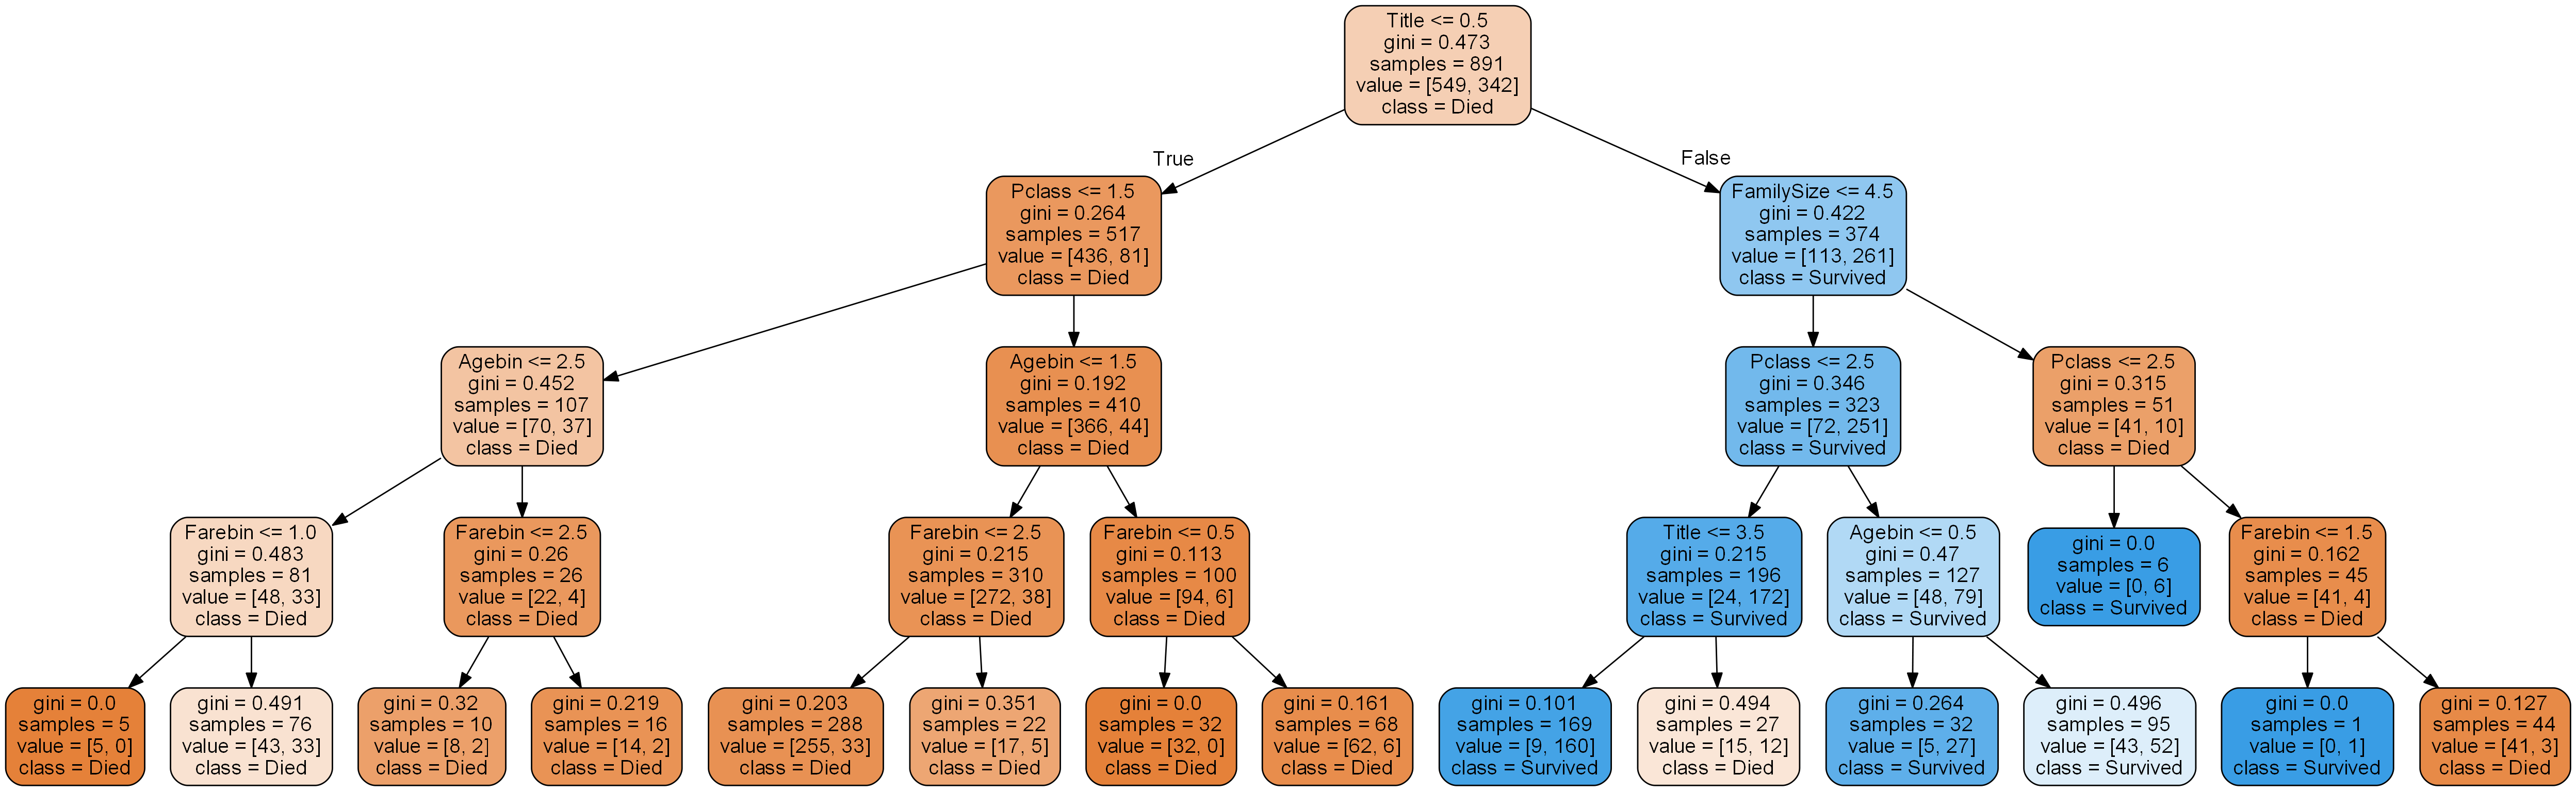

In [12]:
from IPython.display import Image
Image(filename = 'kaggle_tree.png')

# 2. 예측하기

결정트리의 예측방법을 알아보기 전 용어를 먼저 정의한다.  
  
1) **루트 노드(root node)** : 깊이가 0인 맨 꼭대기의 노드  
<br>
2) **자식 노드(child node)** : 하나의 노드에서 분지한 결과  
<br>
3) **리프 노드(leaf node)** : 자식 노드를 가지지 않는 노드  
<br>
4) **samples** : 모델을 훈련할 때 사용한 train 데이터들이다. 하나의 샘플은 한명의 승객에 해당한다.  
<br>
5) **value** : 각 클래스(Survived, Died)별 샘플 수를 리스트로 묶어서 나타낸 것.  
<br>
6) **class** : 예측하고 싶은 분류 기준. target 데이터이며, 캐글 타이타닉에서는 생존여부(Survived, Died)에 해당한다.
{: .notice--info}

모든 노드는 하나의 클래스를 가진다. 가장 많은 샘플이 속해있는 클래스가 해당 노드의 클래스가 된다. 즉 노드의 클래스는 value에 속한 값들 중 가장 큰 값의 클래스를 말한다.  루트 노드의 경우 사망자가 생존자보다 많다. 따라서 루트 노드의 클래스는 'Died'이다.  
  
그렇다면 하나의 샘플에 대해 결정트리는 무엇을 근거로 클래스를 예측하는가? 답은 '리프 노드의 클래스' 이다. 알고리즘에 따라 하나의 모델(결정트리)이 만들어진다. 예측을 위해 test셋에서 하나의 샘플을 가져온다. 모델은 이 샘플이 어떤 리프 노드에 속하는지 판단하여 예측 결과를 반환한다.  
  
예를 들어 test셋에는 892~1309번 승객의 데이터가 들어있다. 이중 903번 승객의 생존 여부를 예측하고자 한다. train셋으로 만들어진 결정트리에 이 승객의 데이터를 넣는다. 데이터를 넣는다는 것은 부모노드에서 자식노드로 내려가는 질문(ex. Pclass<=1.5)에 대해 True or False를 계속 판단하는 것이다. 이 작업을 리프 노드를 만날때까지 반복한다. 903번 승객이 속한 리프 노드의 클래스가 'Survived' 라면 결정트리는 이 승객을 생존자로 분류한다.  

***


# 3. 클래스 확률 추정

결정트리는 한 샘플이 특정 클래스k에 속할 확률을 추정할 수도 있다. 과정은 클래스 예측과 동일하다. 하나의 샘플에 대해 리프 노드를 찾는 것으로 동작한다. 다만 반환 결과가 클래스가 아닌 '확률'이라는 점이 다를 뿐이다.  

test셋에 속한 903번 승객의 클래스 확률을 추정해보자. 우선 승객의 데이터는 다음과 같다.

In [42]:
test_data = test.drop("PassengerId", axis=1)

passenger903 = test_data.loc[[11]] # 892번 승객이 index=0이므로 903번 승객은 index=11
passenger903

Pclass  Sex  Embarked  FamilySize  IsAlone  Title Agebin Farebin
11       1    0         0           1        1      0      3       2

In [41]:
print(clf.predict_proba(passenger903))
print(clf.predict(passenger903))

[[0.8 0.2]]
[0]


사망자 클래스는 0, 생존자 클래스는 1로 나타낸다.  
  
903번 승객이 사망자 집단에 속할 확률은 0.8이다. 실제로 분류기를 통한 예측도 확률이 가장 높은 사망자(0번) 클래스로 예측한다.

***

# 4. CART 훈련 알고리즘

결정트리를 만드는 알고리즘은 여러가지가 있는데 대표적으로 다음과 같다.

1) **CART(classification and regression tree)** : 이진 트리(binary tree) 생성. 불순도 : 지니  
<br>
2) **C4.5** : non-binary tree 생성. 불순도 : 이득 비율  
<br>
3) **CHAID** : non-binary tree 생성. 불순도 : 카이제곱 검정
{: .notice--info}

CART는 훈련 결과 이진 트리를 생성한다. 이진트리는 리프노드를 제외한 모든 노드가 오직 2개의 자식노드를 갖는 트리를 말한다. 즉 질문의 답은 '예' 또는 '아니오'이다. 참고로 사이킷런은 CART를 이용하여 결정 트리를 훈련한다. 
  
결절트리를 훈련한다는 것은 트리의 성장을 의미한다. 트리가 성장한다는 것은 자식 노드를 만들어내는 것이다. 자식 노드를 만들때에는 질문이 필요하다. 예를 들면 'Pclass <= 1.5' 와 같은 것들이다. 질문은 두 가지 요소로 이루어진다. 특성($k$)과 임계값($t_k$)이다. 앞의 예시에서 특성은 `Pclass` 이고 임계값은 1.5이다. 즉 결정트리의 훈련은 특성과 임계값(정확히는 순서쌍 $(k, t_k)$)을 찾는 문제로 귀결된다.  
  
특성과 임계값을 찾는 방법은 다음 식(**CART 비용함수**)을 최소화하는 순서쌍 $(k, t_k)$를 찾는 것이다.  


$$J(k, t_k) = {m_1 \over m}G_1 + {m_2 \over m}G_2$$
  
여기서 $G_1$, $G_2$ 는 자식노드의 지니 불순도이고 $m_1$, $m_2$는 자식 노드의 샘플 수이다. $m$은 부모 노드의 샘플 수이다. 즉 $m=m_1 + m_2$  
  
지니 불순도는 하나의 노드마다 개별적으로 계산되며 공식은 다음과 같다.

$$G = 1 - \sum_{k=1}^n {p_k}^2$$

여기서 $p_k$는 노드에 있는 샘플들 중 클래스 k에 속한 샘플의 비율이다. 예를 들어 루트 노드의 $gini=0.473$은 다음과 같이 계산 된다.

$$0.473 = 1 - \left( {549 \over 891} \right)^2 - \left( {342 \over 891} \right)^2$$

***

# 5. 규제 매개변수

결정트리는 모델 파라미터를 따로 설정하지 않을 경우 제약이 없고 매우 높은 자유도를 갖는 모델이 만들어진다. 이런 경우 훈련 데이터에 과대적합된 모델이 만들어질 가능성이 높다. 처음 결정트리를 시각화 할 때 모델 파라미터로써 `max_depth=4`를 설정했다. 이는 트리의 최대 깊이를 4로 제한하는 규제 매개변수이다. 규제가 없는 결정 트리는 다음과 같다.

In [6]:
# 규제 없는 모델 훈련
clf_none = DecisionTreeClassifier()
clf_none.fit(train_data, target)

export_graphviz(clf_none, 
                out_file='kaggle_tree_none.dot', 
                feature_names=list(train_data), 
                class_names=['Died','Survived'], 
                rounded=True, 
                filled=True)

In [7]:
!dot -Tpng kaggle_tree_none.dot -o kaggle_tree_none.png -Gdpi=100

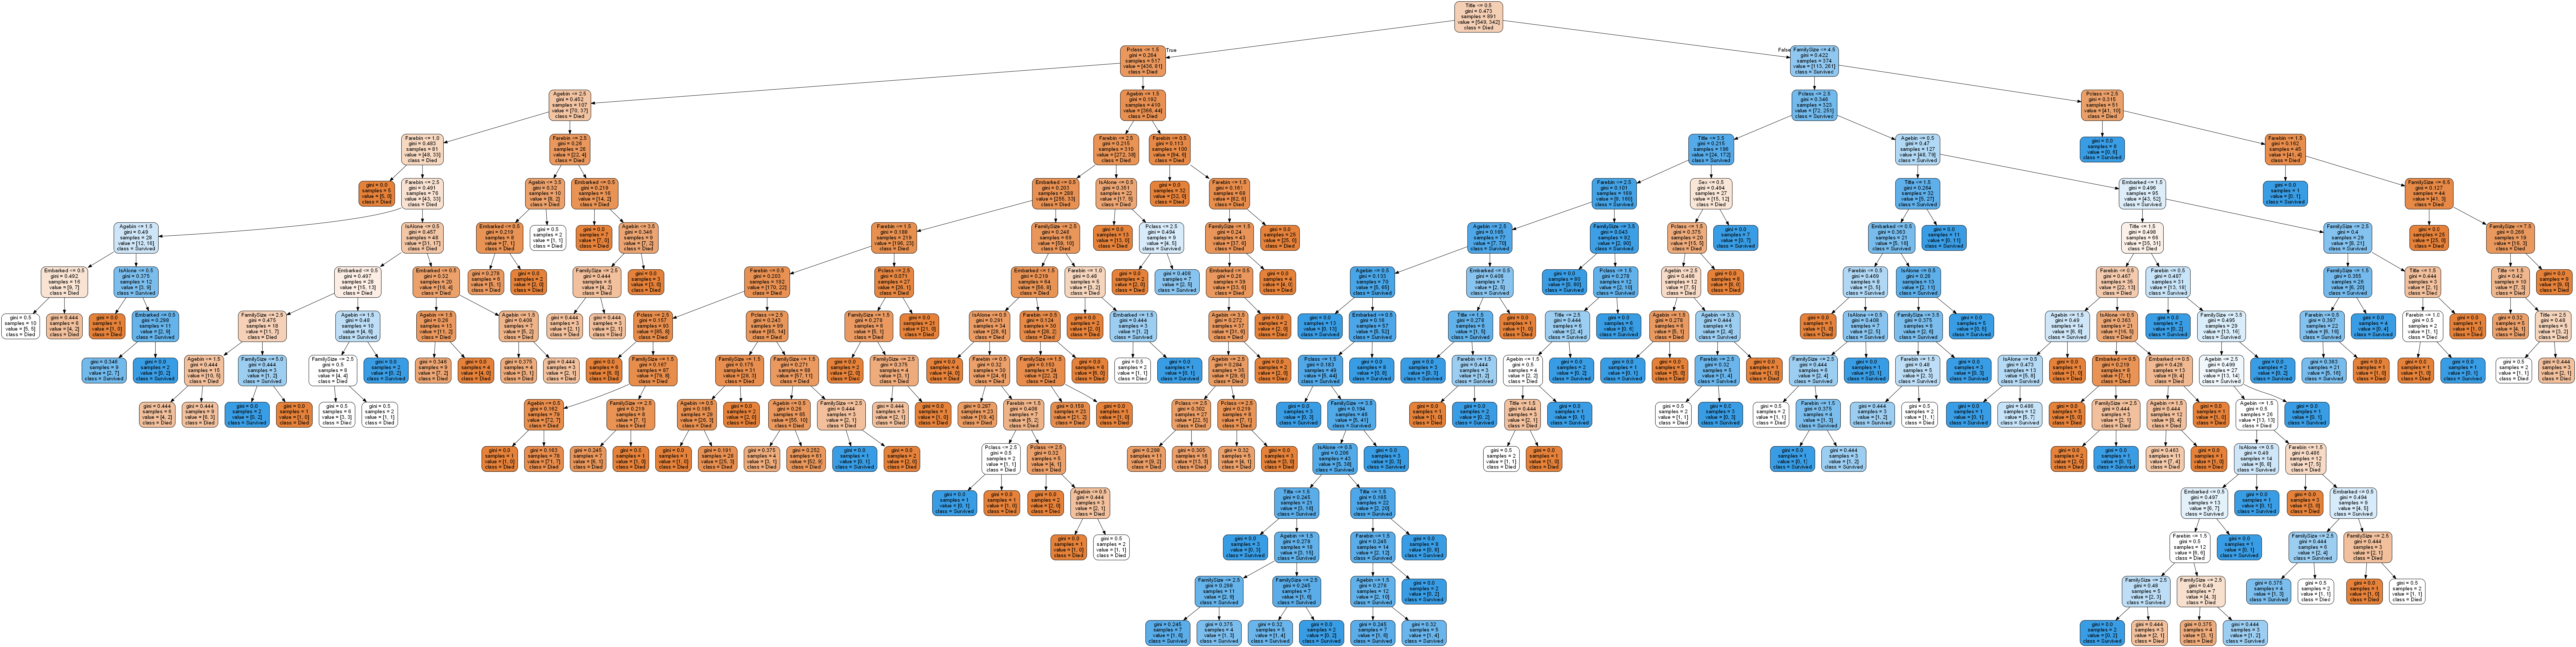

In [8]:
from IPython.display import Image
Image(filename = 'kaggle_tree_none.png')

이처럼 과도하게 복잡한 트리를 방지하기 위한 것이 규제 매개변수이다. 사이킷런에서는 결정트리의 규제를 위한 매개변수를 여러개 제공한다. 일반적으로 `min_`으로 시작하는 매개변수를 증가시키거나 `max_`로 시작하는 매개변수를 감소시킬 때 모델에 대한 규제가 커진다.  
  
자주 이용하는 규제 매개변수는 다음과 같다.  
  
1) **max_depth** : 트리의 최대 깊이  
<br>
2) **max_leaf_nodes** : 리프 노드의 최대 수  
<br>
3) **max_features** : 각 노드에서 분할에 사용할 특성의 최대 수  
<br>
4) **min_samples_leaf** : 리프 노드가 가지고 있어야 할 최소 샘플 수  
<br>
5) **min_samples_split** : 분할되기 위해 노드가 가져야 하는 최소 샘플 수
{: .notice--info}
  
그 외 결정트리의 모델 파라미터에 대한 정보는 아래 링크에서 확인할 수 있다.

[결정트리 모델 파라미터](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decision#sklearn.tree.DecisionTreeClassifier)
{: .notice--success}

***

# 6. 회귀

결정 트리는 기본적으로 분류기를 만드는 알고리즘이지만 회귀 문제에도 사용할 수 있다. 트리를 이용하여 2차 함수 형태의 곡선을 추정하는 회귀 문제를 풀어보자. 기존의 회귀 문제와 다른 점은 훈련 결과 얻어지는 것이 가중치(다항식의 계수)가 아니라 트리라는 것이다.

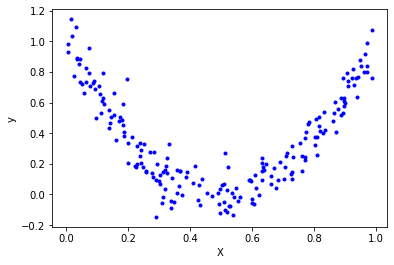

In [31]:
import matplotlib.pyplot as plt

# 2차식으로 만든 데이터셋 + 잡음
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

# 잡음이 들어간 데이터셋을 좌표평면에 표현
plt.plot(X,y, "b.")
plt.xlabel('X')
plt.ylabel('y')
plt.show()

위 그림은 이차함수 $y=4(x-0.5)^2$ 을 통해 잡음을 추가하여 좌표평면에 랜덤한 200개의 점을 찍은 것이다. $X=0.5$ 를 기준으로 아래로 볼록한 개형을 그리는 것을 확인할 수 있다. **트리는 이 점들의 분포를 어떻게 설명하는가?** 하는 것이 우리의 관심사이다. 회귀 트리 패키지를 통해 데이터를 훈련시켜보자.

In [24]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(max_depth=2)
reg.fit(X,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

생성된 트리를 시각화하면 다음과 같다.

In [70]:
export_graphviz(reg, 
                out_file='kaggle_tree_reg.dot', 
                feature_names=['x'], 
                rounded=True, 
                filled=True)

In [71]:
!dot -Tpng kaggle_tree_reg.dot -o kaggle_tree_reg.png -Gdpi=300

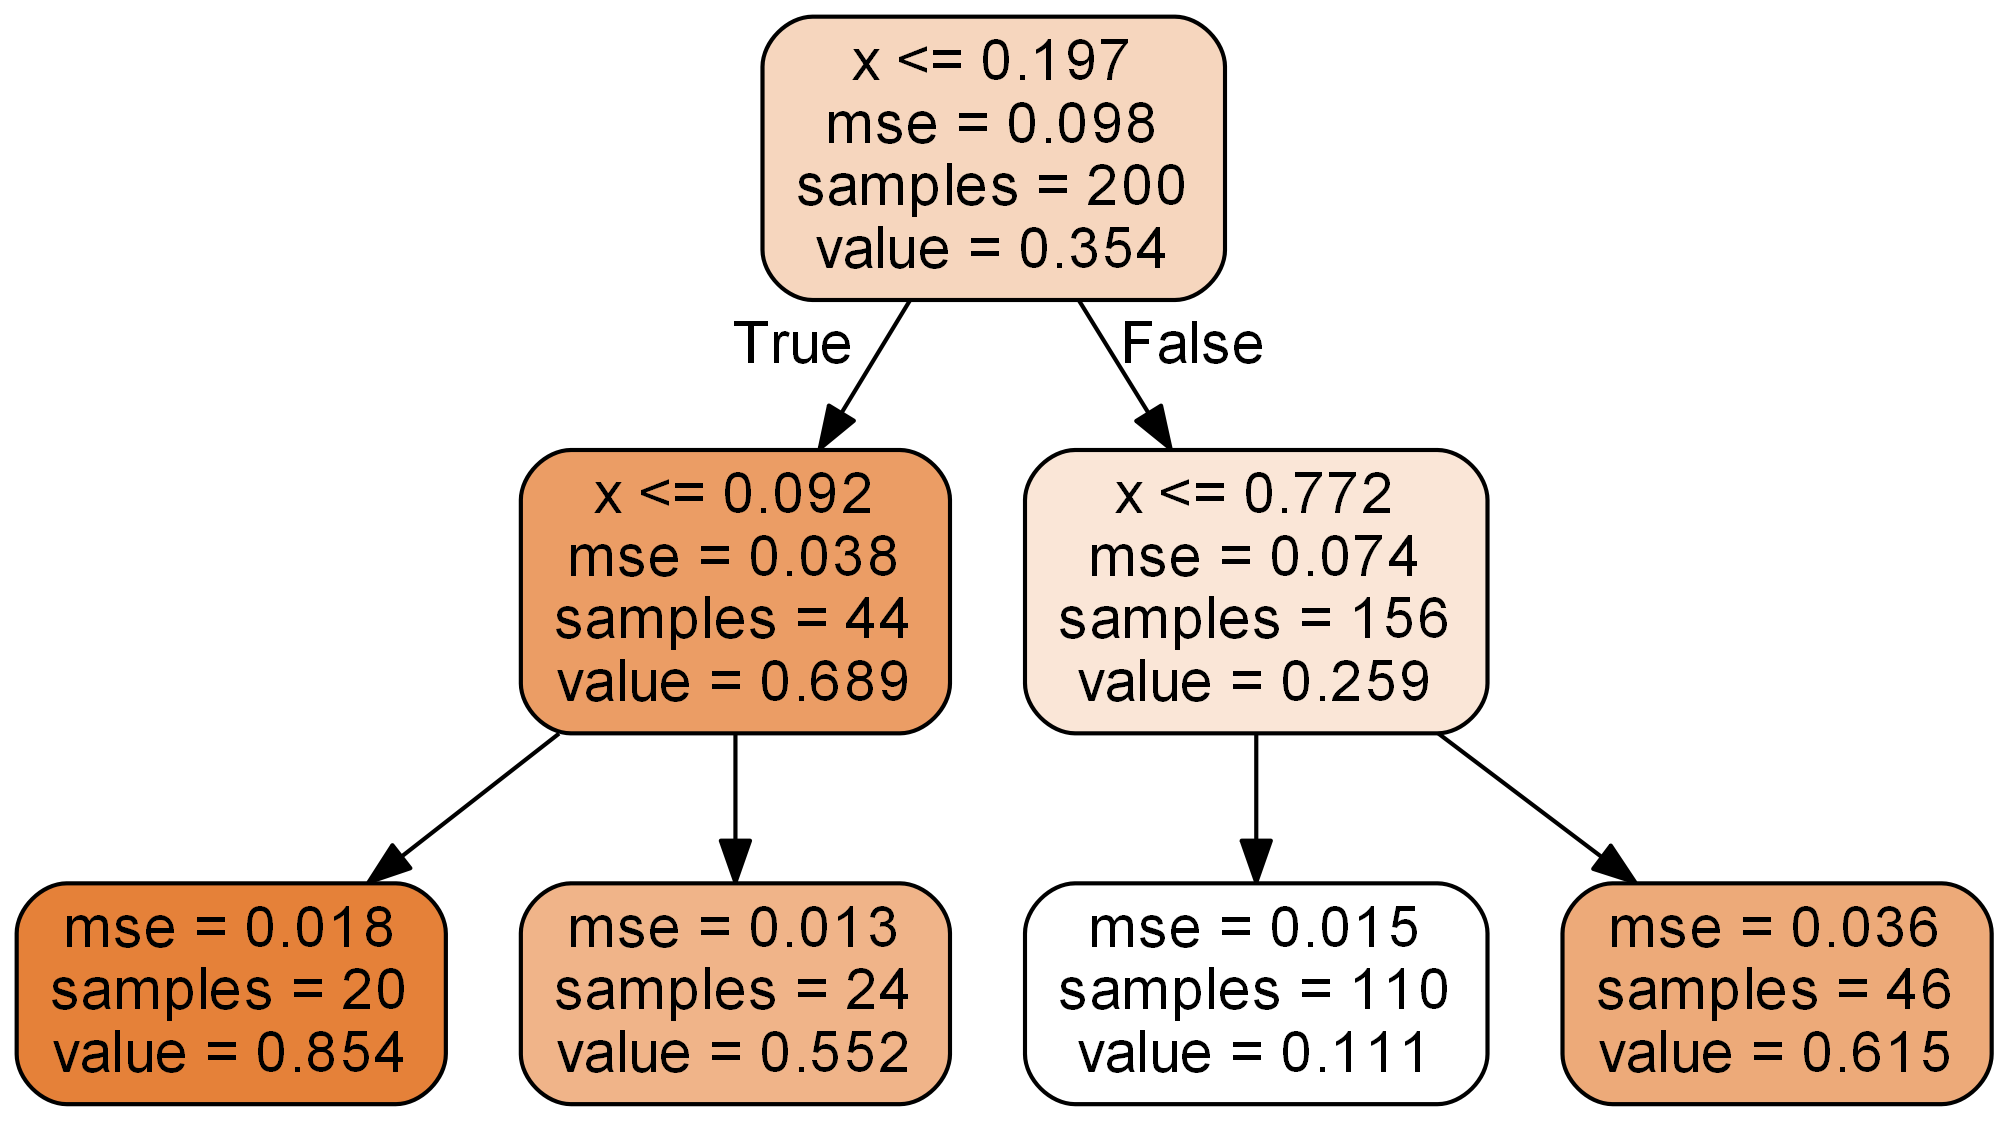

In [72]:
Image(filename = 'kaggle_tree_reg.png')

분류 트리에서 각 노드가 예측한 것은 'class'였다. 그러나 회귀 트리에서 각 노드들은 'value'를 예측한다. 즉 회귀 트리가 반환하는 결과는 어떤 실수값이다. 각 노드의 value는 노드에 속한 샘플들의 '평균'으로 정해진다. 루트 노드의 경우 점 200개의 y값들 평균이 0.354가 되는 것이다.  
  
그렇다면 회귀트리는 하나의 샘플에 대해 value를 어떻게 예측하는가? 분류트리와 마찬가지이다. **리프 노드의 value**로 샘플의 값을 예측한다. 깊이가 2인 회귀 트리를 좌표평면상에 나타내면 다음과 같다.

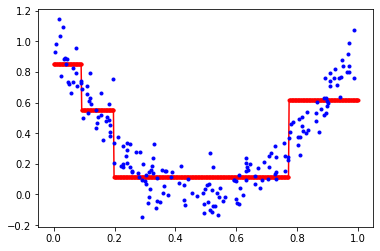

In [66]:
x=np.linspace(0,1,500).reshape(-1,1)
y_pred = reg.predict(x)
plt.plot(x,y_pred, 'r.-')
plt.plot(X,y,'b.')
plt.show()

붉은색 가로선이 샘플들에 대한 트리의 예측 값이 된다. 리프 노드에 속한 샘플들은 모두 같은 value를 갖기 때문에 회귀 트리는 계단 형태의 그래프를 그린다. 계단의 경계는 각 노드를 분할하는 임계값이 된다. 위 트리의 경우 임계값은 `0.092, 0.197, 0.772`이다.
  
깊이가 3인 회귀 트리도 시각화해보자.

In [73]:
reg2=DecisionTreeRegressor(max_depth=3)
reg2.fit(X,y)

export_graphviz(reg2, 
                out_file='kaggle_tree_reg2.dot', 
                feature_names=['x'], 
                rounded=True, 
                filled=True)

In [74]:
!dot -Tpng kaggle_tree_reg2.dot -o kaggle_tree_reg2.png -Gdpi=300

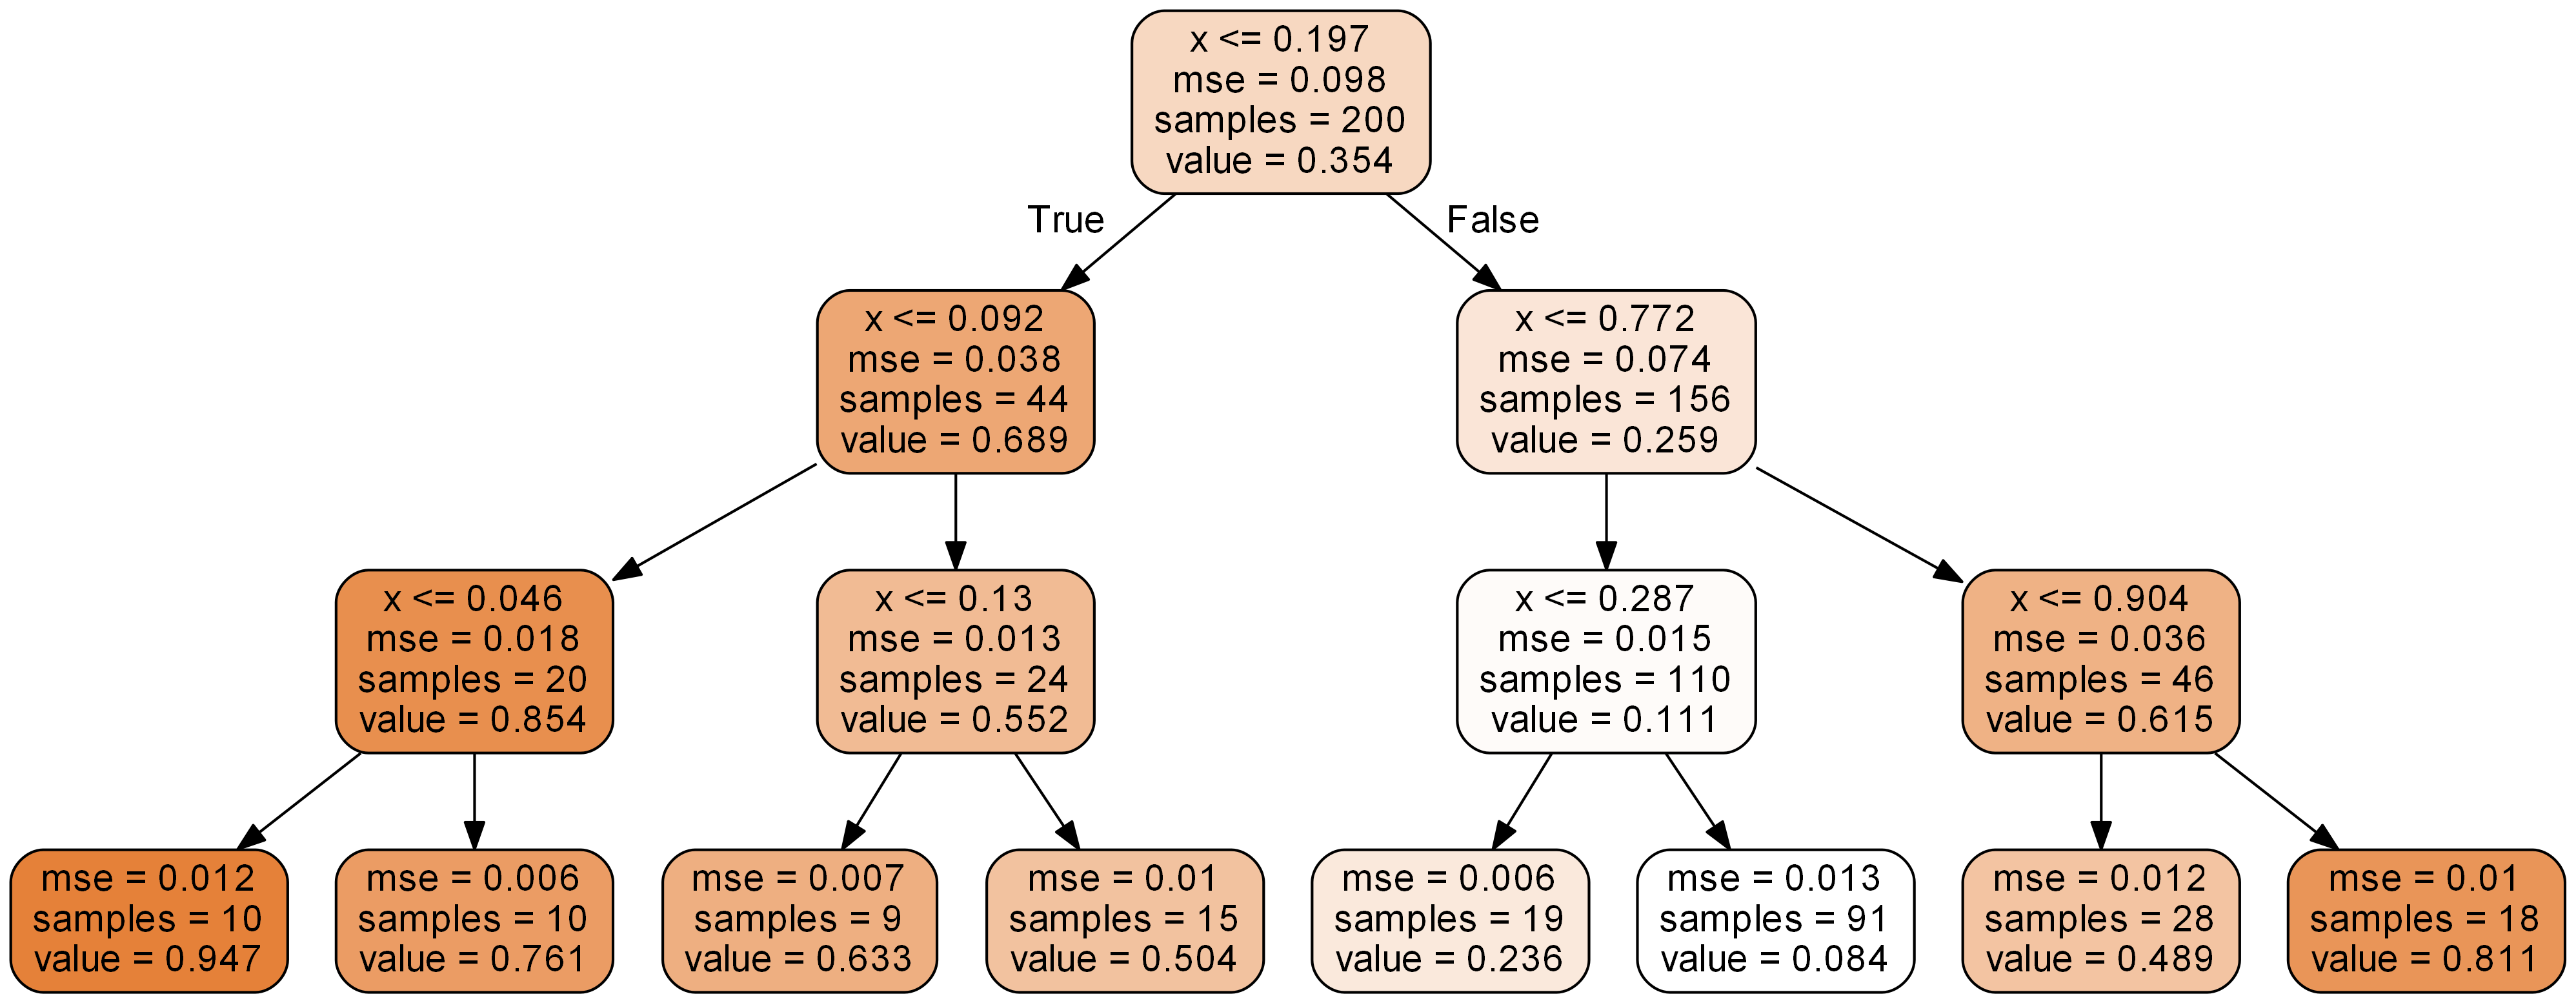

In [75]:
Image(filename = 'kaggle_tree_reg2.png')

그래프를 그리면 다음과 같다.

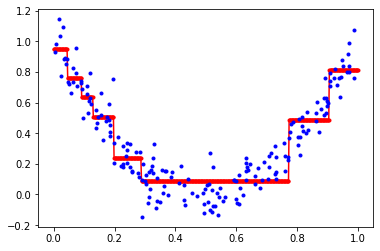

In [76]:
x=np.linspace(0,1,500).reshape(-1,1)
y_pred2 = reg2.predict(x)
plt.plot(x,y_pred2, 'r.-')
plt.plot(X,y,'b.')
plt.show()

회귀 트리의 훈련, 그래프를 그리는데 가장 결정적인 요소는 결국 각 노드의 '임계값'이다. 노드의 임계값은 어떻게 설정되는가? 분류 트리와 유사하다. 다음 비용 함수 값을 최소화하는 방향으로 임계값이 설정되고 노드를 분할한다.

$$J(k,t_k) = {m_1 \over m}MSE_1 + {m_2 \over m}MSE_2$$

여기서 $MSE_1$, $MSE_2$는 자식 노드의 평균제곱오차이고 $m_1$, $m_2$는 자식 노드의 샘플 수이다. 평균제곱오차는 다음 식으로 구한다.

$$MSE_{node} = {1 \over m_{node}}\sum_{i \in node}{\left( \hat{y}_{node} - y^{(i)} \right)^2}$$  
$$\hat{y}_{node} = {1 \over m_{node}}\sum_{i \in node}{y^{(i)}}$$


# Reference

핸즈온 머신러닝 2판 (오렐리앙 제롱 지음. 박해선 옮김)
{: .notice--success}